In [1]:
### import packages ###
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
def demary_2008(T,N,sig_s_f_er,bet,d,gam,tau):
    """
    This function simulates the model from Demary 2009
    A version of the paper can be found on
    https://www.degruyter.com/document/doi/10.5018/economics-ejournal.ja.2010-8/html

    Parameters
    ----------
    T : int
        Max. Timeperiod
    N : int
        Max. Investment Horizon 
    sig_s_f_er : float
        fundamental rate error variance
    bet : float
        price adjustment speed
    d : float
        memory parameter
    gam : int
        intensity of choice
    tau : float
        tax rate

    Returns
    -------
    
    s   : float
        log exchange rate
        
    s_f   : float
        fudamental value
    dem : float
        matrix of demand of each trader. 
        row 1: short-chart
        row 2: short fund
        row 3: long chart 
        row 4: long fund
    atrac: float 
        atracticity of the trading rules
        row 1: short-chart
        row 2: short fund
        row 3: long chart 
        row 4: long fund
        row 5: no 
        
    weig: float 
        weights of the trading rules
        row 1: short-chart
        row 2: short fund
        row 3: long chart 
        row 4: long fund
        row 5: no trading
    """
    ### Parameters ###
    kc = 0.04   # chartis`s reaction
    kf = 0.04   # fundamentalists reaction 
    sig_c = 0.03    # vareity of chartists rules
    sig_f = 0.005    # vareity of fundamental news
    sig_s = 0.01    # non-fundamental news 
    
    
    ### Preallocation ###
    # baseline parameter
    s = np.zeros(T)
    s_f = np.zeros(T)
    dem = np.zeros([4,T])
    tot_de  = np.zeros(T)
    # random parameter
    c_er = np.random.normal(0,sig_c,T)
    f_er = np.random.normal(0,sig_f,T)
    s_er = np.random.normal(0,sig_s,T)
    s_f_er = np.random.normal(0,sig_s_f_er,T)
    # fitness function
    atrac = np.zeros([5,T])
    # weights of the strategies
    weig = np.zeros([5,T])
   
    
    ### functions ###
    def atractivity(s_t,s_t1,D,A,P):
       
        return (np.exp(s_t)-np.exp(s_t1))*D/P - tau*(np.exp(s_t) + np.exp(s_t1)) * abs(D)/P  + d*A
    
    def weights(A1,A2,A3,A4,A5):
         vec = np.array([gam*A1, gam*A2, gam*A3, gam*A4, gam*A5])
         max_vec = np.amax(vec)
         return np.exp(gam*A1-max_vec)/ (np.exp(gam*A1-max_vec)+np.exp(gam*A2-max_vec)+np.exp(gam*A3-max_vec)+np.exp(gam*A4-max_vec)+np.exp(gam*A5-max_vec))
         
    ### Loop ###
    
    for t in range(30,T-1):
        s_f[t] = s_f[t-1] + s_f_er[t]
        
        
        dem[0,t] = kc*(s[t]-s[t-1])+c_er[t]
        dem[1,t] = kf*(s_f[t] - s[t]) + f_er[t]
        dem[2,t] = ((1-kc**N)/(1-kc)*kc)*(s[t]-s[t-1])
        dem[3,t] = (1-(1-kf)**N)*(s_f[t]-s[t])
        
        atrac[0,t] = atractivity(s_t=s[t], s_t1=s[t-1], D=dem[0,t-2], A=atrac[0,t-1], P = 1)
        atrac[1,t] = atractivity(s_t=s[t], s_t1=s[t-1], D=dem[1,t-2], A=atrac[1,t-1], P = 1)
        atrac[2,t] = atractivity(s_t=s[t], s_t1=s[t-N], D=dem[2,t-N-1], A=atrac[2,t-1], P = N)
        atrac[3,t] = atractivity(s_t=s[t], s_t1=s[t-N], D=dem[3,t-N-1], A=atrac[3,t-1], P = N )
        
        weig[0,t] = weights(A1=atrac[0,t], A2= atrac[1,t], A3 = atrac[2,t], A4 = atrac[3,t], A5 = atrac[4,t])
        weig[1,t] = weights(A1=atrac[1,t], A2= atrac[0,t], A3 = atrac[2,t], A4 = atrac[3,t], A5 = atrac[4,t])
        weig[2,t] = weights(A1=atrac[2,t], A2= atrac[0,t], A3 = atrac[1,t], A4 = atrac[3,t], A5 = atrac[4,t])
        weig[3,t] = weights(A1=atrac[3,t], A2= atrac[0,t], A3 = atrac[2,t], A4 = atrac[1,t], A5 = atrac[4,t])
        weig[4,t] = weights(A1=atrac[4,t], A2= atrac[0,t], A3 = atrac[2,t], A4 = atrac[3,t], A5 = atrac[1,t])
        
        tot_de[t] = weig[0,t]*dem[0,t] + weig[1,t]*dem[1,t] +weig[2,t]*dem[2,t] +weig[3,t]*dem[3,t]
        s[t+1] = s[t] + bet * tot_de[t] + s_er[t]

    return(s,s_f,dem,atrac,weig)

In [45]:
# Simulation

tax = np.arange(0,0.035,0.001)
T = 5000
numSim = 100

s = np.zeros([numSim, T])
s_f = np.zeros([numSim, T])
s_avg = np.zeros([len(tax),T])
s_f_avg = np.zeros([len(tax),T])

for i in tqdm(range(len(tax))):
    for num in range(numSim):
        np.random.seed(100 + num)
        #####################################################################
        s[num,:],s_f[num,:],_,_,_= demary_2008(T,30,0,1,0.975,800,tax[i])
        #####################################################################
    s_avg[i,:] = np.mean(s, axis = 0)
    s_f_avg[i,:] = np.mean(s_f, axis = 0)



Num Tax:0NumSim:0
Num Tax:0NumSim:1
Num Tax:0NumSim:2
Num Tax:0NumSim:3
Num Tax:0NumSim:4
Num Tax:0NumSim:5
Num Tax:0NumSim:6
Num Tax:0NumSim:7
Num Tax:0NumSim:8
Num Tax:0NumSim:9
Num Tax:0NumSim:10
Num Tax:0NumSim:11
Num Tax:0NumSim:12
Num Tax:0NumSim:13
Num Tax:0NumSim:14
Num Tax:0NumSim:15
Num Tax:0NumSim:16
Num Tax:0NumSim:17
Num Tax:0NumSim:18
Num Tax:0NumSim:19
Num Tax:0NumSim:20
Num Tax:0NumSim:21
Num Tax:0NumSim:22
Num Tax:0NumSim:23
Num Tax:0NumSim:24
Num Tax:0NumSim:25
Num Tax:0NumSim:26
Num Tax:0NumSim:27
Num Tax:0NumSim:28
Num Tax:0NumSim:29
Num Tax:0NumSim:30
Num Tax:0NumSim:31
Num Tax:0NumSim:32
Num Tax:0NumSim:33
Num Tax:0NumSim:34
Num Tax:0NumSim:35
Num Tax:0NumSim:36
Num Tax:0NumSim:37
Num Tax:0NumSim:38
Num Tax:0NumSim:39
Num Tax:0NumSim:40
Num Tax:0NumSim:41
Num Tax:0NumSim:42
Num Tax:0NumSim:43
Num Tax:0NumSim:44
Num Tax:0NumSim:45
Num Tax:0NumSim:46
Num Tax:0NumSim:47
Num Tax:0NumSim:48
Num Tax:0NumSim:49
Num Tax:0NumSim:50
Num Tax:0NumSim:51
Num Tax:0NumSim:52
Num

Num Tax:4NumSim:34
Num Tax:4NumSim:35
Num Tax:4NumSim:36
Num Tax:4NumSim:37
Num Tax:4NumSim:38
Num Tax:4NumSim:39
Num Tax:4NumSim:40
Num Tax:4NumSim:41
Num Tax:4NumSim:42
Num Tax:4NumSim:43
Num Tax:4NumSim:44
Num Tax:4NumSim:45
Num Tax:4NumSim:46
Num Tax:4NumSim:47
Num Tax:4NumSim:48
Num Tax:4NumSim:49
Num Tax:4NumSim:50
Num Tax:4NumSim:51
Num Tax:4NumSim:52
Num Tax:4NumSim:53
Num Tax:4NumSim:54
Num Tax:4NumSim:55
Num Tax:4NumSim:56
Num Tax:4NumSim:57
Num Tax:4NumSim:58
Num Tax:4NumSim:59
Num Tax:4NumSim:60
Num Tax:4NumSim:61
Num Tax:4NumSim:62
Num Tax:4NumSim:63
Num Tax:4NumSim:64
Num Tax:4NumSim:65
Num Tax:4NumSim:66
Num Tax:4NumSim:67
Num Tax:4NumSim:68
Num Tax:4NumSim:69
Num Tax:4NumSim:70
Num Tax:4NumSim:71
Num Tax:4NumSim:72
Num Tax:4NumSim:73
Num Tax:4NumSim:74
Num Tax:4NumSim:75
Num Tax:4NumSim:76
Num Tax:4NumSim:77
Num Tax:4NumSim:78
Num Tax:4NumSim:79
Num Tax:4NumSim:80
Num Tax:4NumSim:81
Num Tax:4NumSim:82
Num Tax:4NumSim:83
Num Tax:4NumSim:84
Num Tax:4NumSim:85
Num Tax:4Num

Num Tax:8NumSim:68
Num Tax:8NumSim:69
Num Tax:8NumSim:70
Num Tax:8NumSim:71
Num Tax:8NumSim:72
Num Tax:8NumSim:73
Num Tax:8NumSim:74
Num Tax:8NumSim:75
Num Tax:8NumSim:76
Num Tax:8NumSim:77
Num Tax:8NumSim:78
Num Tax:8NumSim:79
Num Tax:8NumSim:80
Num Tax:8NumSim:81
Num Tax:8NumSim:82
Num Tax:8NumSim:83
Num Tax:8NumSim:84
Num Tax:8NumSim:85
Num Tax:8NumSim:86
Num Tax:8NumSim:87
Num Tax:8NumSim:88
Num Tax:8NumSim:89
Num Tax:8NumSim:90
Num Tax:8NumSim:91
Num Tax:8NumSim:92
Num Tax:8NumSim:93
Num Tax:8NumSim:94
Num Tax:8NumSim:95
Num Tax:8NumSim:96
Num Tax:8NumSim:97
Num Tax:8NumSim:98
Num Tax:8NumSim:99
Num Tax:9NumSim:0
Num Tax:9NumSim:1
Num Tax:9NumSim:2
Num Tax:9NumSim:3
Num Tax:9NumSim:4
Num Tax:9NumSim:5
Num Tax:9NumSim:6
Num Tax:9NumSim:7
Num Tax:9NumSim:8
Num Tax:9NumSim:9
Num Tax:9NumSim:10
Num Tax:9NumSim:11
Num Tax:9NumSim:12
Num Tax:9NumSim:13
Num Tax:9NumSim:14
Num Tax:9NumSim:15
Num Tax:9NumSim:16
Num Tax:9NumSim:17
Num Tax:9NumSim:18
Num Tax:9NumSim:19
Num Tax:9NumSim:20
Num

Num Tax:12NumSim:87
Num Tax:12NumSim:88
Num Tax:12NumSim:89
Num Tax:12NumSim:90
Num Tax:12NumSim:91
Num Tax:12NumSim:92
Num Tax:12NumSim:93
Num Tax:12NumSim:94
Num Tax:12NumSim:95
Num Tax:12NumSim:96
Num Tax:12NumSim:97
Num Tax:12NumSim:98
Num Tax:12NumSim:99
Num Tax:13NumSim:0
Num Tax:13NumSim:1
Num Tax:13NumSim:2
Num Tax:13NumSim:3
Num Tax:13NumSim:4
Num Tax:13NumSim:5
Num Tax:13NumSim:6
Num Tax:13NumSim:7
Num Tax:13NumSim:8
Num Tax:13NumSim:9
Num Tax:13NumSim:10
Num Tax:13NumSim:11
Num Tax:13NumSim:12
Num Tax:13NumSim:13
Num Tax:13NumSim:14
Num Tax:13NumSim:15
Num Tax:13NumSim:16
Num Tax:13NumSim:17
Num Tax:13NumSim:18
Num Tax:13NumSim:19
Num Tax:13NumSim:20
Num Tax:13NumSim:21
Num Tax:13NumSim:22
Num Tax:13NumSim:23
Num Tax:13NumSim:24
Num Tax:13NumSim:25
Num Tax:13NumSim:26
Num Tax:13NumSim:27
Num Tax:13NumSim:28
Num Tax:13NumSim:29
Num Tax:13NumSim:30
Num Tax:13NumSim:31
Num Tax:13NumSim:32
Num Tax:13NumSim:33
Num Tax:13NumSim:34
Num Tax:13NumSim:35
Num Tax:13NumSim:36
Num Tax:13

Num Tax:16NumSim:99
Num Tax:17NumSim:0
Num Tax:17NumSim:1
Num Tax:17NumSim:2
Num Tax:17NumSim:3
Num Tax:17NumSim:4
Num Tax:17NumSim:5
Num Tax:17NumSim:6
Num Tax:17NumSim:7
Num Tax:17NumSim:8
Num Tax:17NumSim:9
Num Tax:17NumSim:10
Num Tax:17NumSim:11
Num Tax:17NumSim:12
Num Tax:17NumSim:13
Num Tax:17NumSim:14
Num Tax:17NumSim:15
Num Tax:17NumSim:16
Num Tax:17NumSim:17
Num Tax:17NumSim:18
Num Tax:17NumSim:19
Num Tax:17NumSim:20
Num Tax:17NumSim:21
Num Tax:17NumSim:22
Num Tax:17NumSim:23
Num Tax:17NumSim:24
Num Tax:17NumSim:25
Num Tax:17NumSim:26
Num Tax:17NumSim:27
Num Tax:17NumSim:28
Num Tax:17NumSim:29
Num Tax:17NumSim:30
Num Tax:17NumSim:31
Num Tax:17NumSim:32
Num Tax:17NumSim:33
Num Tax:17NumSim:34
Num Tax:17NumSim:35
Num Tax:17NumSim:36
Num Tax:17NumSim:37
Num Tax:17NumSim:38
Num Tax:17NumSim:39
Num Tax:17NumSim:40
Num Tax:17NumSim:41
Num Tax:17NumSim:42
Num Tax:17NumSim:43
Num Tax:17NumSim:44
Num Tax:17NumSim:45
Num Tax:17NumSim:46
Num Tax:17NumSim:47
Num Tax:17NumSim:48
Num Tax:17

Num Tax:21NumSim:12
Num Tax:21NumSim:13
Num Tax:21NumSim:14
Num Tax:21NumSim:15
Num Tax:21NumSim:16
Num Tax:21NumSim:17
Num Tax:21NumSim:18
Num Tax:21NumSim:19
Num Tax:21NumSim:20
Num Tax:21NumSim:21
Num Tax:21NumSim:22
Num Tax:21NumSim:23
Num Tax:21NumSim:24
Num Tax:21NumSim:25
Num Tax:21NumSim:26
Num Tax:21NumSim:27
Num Tax:21NumSim:28
Num Tax:21NumSim:29
Num Tax:21NumSim:30
Num Tax:21NumSim:31
Num Tax:21NumSim:32
Num Tax:21NumSim:33
Num Tax:21NumSim:34
Num Tax:21NumSim:35
Num Tax:21NumSim:36
Num Tax:21NumSim:37
Num Tax:21NumSim:38
Num Tax:21NumSim:39
Num Tax:21NumSim:40
Num Tax:21NumSim:41
Num Tax:21NumSim:42
Num Tax:21NumSim:43
Num Tax:21NumSim:44
Num Tax:21NumSim:45
Num Tax:21NumSim:46
Num Tax:21NumSim:47
Num Tax:21NumSim:48
Num Tax:21NumSim:49
Num Tax:21NumSim:50
Num Tax:21NumSim:51
Num Tax:21NumSim:52
Num Tax:21NumSim:53
Num Tax:21NumSim:54
Num Tax:21NumSim:55
Num Tax:21NumSim:56
Num Tax:21NumSim:57
Num Tax:21NumSim:58
Num Tax:21NumSim:59
Num Tax:21NumSim:60
Num Tax:21NumSim:61


Num Tax:25NumSim:24
Num Tax:25NumSim:25
Num Tax:25NumSim:26
Num Tax:25NumSim:27
Num Tax:25NumSim:28
Num Tax:25NumSim:29
Num Tax:25NumSim:30
Num Tax:25NumSim:31
Num Tax:25NumSim:32
Num Tax:25NumSim:33
Num Tax:25NumSim:34
Num Tax:25NumSim:35
Num Tax:25NumSim:36
Num Tax:25NumSim:37
Num Tax:25NumSim:38
Num Tax:25NumSim:39
Num Tax:25NumSim:40
Num Tax:25NumSim:41
Num Tax:25NumSim:42
Num Tax:25NumSim:43
Num Tax:25NumSim:44
Num Tax:25NumSim:45
Num Tax:25NumSim:46
Num Tax:25NumSim:47
Num Tax:25NumSim:48
Num Tax:25NumSim:49
Num Tax:25NumSim:50
Num Tax:25NumSim:51
Num Tax:25NumSim:52
Num Tax:25NumSim:53
Num Tax:25NumSim:54
Num Tax:25NumSim:55
Num Tax:25NumSim:56
Num Tax:25NumSim:57
Num Tax:25NumSim:58
Num Tax:25NumSim:59
Num Tax:25NumSim:60
Num Tax:25NumSim:61
Num Tax:25NumSim:62
Num Tax:25NumSim:63
Num Tax:25NumSim:64
Num Tax:25NumSim:65
Num Tax:25NumSim:66
Num Tax:25NumSim:67
Num Tax:25NumSim:68
Num Tax:25NumSim:69
Num Tax:25NumSim:70
Num Tax:25NumSim:71
Num Tax:25NumSim:72
Num Tax:25NumSim:73


Num Tax:29NumSim:36
Num Tax:29NumSim:37
Num Tax:29NumSim:38
Num Tax:29NumSim:39
Num Tax:29NumSim:40
Num Tax:29NumSim:41
Num Tax:29NumSim:42
Num Tax:29NumSim:43
Num Tax:29NumSim:44
Num Tax:29NumSim:45
Num Tax:29NumSim:46
Num Tax:29NumSim:47
Num Tax:29NumSim:48
Num Tax:29NumSim:49
Num Tax:29NumSim:50
Num Tax:29NumSim:51
Num Tax:29NumSim:52
Num Tax:29NumSim:53
Num Tax:29NumSim:54
Num Tax:29NumSim:55
Num Tax:29NumSim:56
Num Tax:29NumSim:57
Num Tax:29NumSim:58
Num Tax:29NumSim:59
Num Tax:29NumSim:60
Num Tax:29NumSim:61
Num Tax:29NumSim:62
Num Tax:29NumSim:63
Num Tax:29NumSim:64
Num Tax:29NumSim:65
Num Tax:29NumSim:66
Num Tax:29NumSim:67
Num Tax:29NumSim:68
Num Tax:29NumSim:69
Num Tax:29NumSim:70
Num Tax:29NumSim:71
Num Tax:29NumSim:72
Num Tax:29NumSim:73
Num Tax:29NumSim:74
Num Tax:29NumSim:75
Num Tax:29NumSim:76
Num Tax:29NumSim:77
Num Tax:29NumSim:78
Num Tax:29NumSim:79
Num Tax:29NumSim:80
Num Tax:29NumSim:81
Num Tax:29NumSim:82
Num Tax:29NumSim:83
Num Tax:29NumSim:84
Num Tax:29NumSim:85


Num Tax:33NumSim:48
Num Tax:33NumSim:49
Num Tax:33NumSim:50
Num Tax:33NumSim:51
Num Tax:33NumSim:52
Num Tax:33NumSim:53
Num Tax:33NumSim:54
Num Tax:33NumSim:55
Num Tax:33NumSim:56
Num Tax:33NumSim:57
Num Tax:33NumSim:58
Num Tax:33NumSim:59
Num Tax:33NumSim:60
Num Tax:33NumSim:61
Num Tax:33NumSim:62
Num Tax:33NumSim:63
Num Tax:33NumSim:64
Num Tax:33NumSim:65
Num Tax:33NumSim:66
Num Tax:33NumSim:67
Num Tax:33NumSim:68
Num Tax:33NumSim:69
Num Tax:33NumSim:70
Num Tax:33NumSim:71
Num Tax:33NumSim:72
Num Tax:33NumSim:73
Num Tax:33NumSim:74
Num Tax:33NumSim:75
Num Tax:33NumSim:76
Num Tax:33NumSim:77
Num Tax:33NumSim:78
Num Tax:33NumSim:79
Num Tax:33NumSim:80
Num Tax:33NumSim:81
Num Tax:33NumSim:82
Num Tax:33NumSim:83
Num Tax:33NumSim:84
Num Tax:33NumSim:85
Num Tax:33NumSim:86
Num Tax:33NumSim:87
Num Tax:33NumSim:88
Num Tax:33NumSim:89
Num Tax:33NumSim:90
Num Tax:33NumSim:91
Num Tax:33NumSim:92
Num Tax:33NumSim:93
Num Tax:33NumSim:94
Num Tax:33NumSim:95
Num Tax:33NumSim:96
Num Tax:33NumSim:97


In [46]:
vol = np.zeros(len(tax))
dis = np.zeros(len(tax))

def volatility(s):
    abs_dev = np.zeros(len(s))
    for i in range(50,len(s)):
        abs_dev[i] = np.abs(s[i] - s[i-1])
    
    return 1/len(abs_dev)*np.sum(abs_dev)

def distortion(s,s_f):
    dev_fund = np.zeros(len(s))
    for i in range(50,len(s)):
        dev_fund[i] = np.abs(s_f[i] - s[i])
    return 1/len(dev_fund) * np.sum(dev_fund)



In [47]:
#tax = np.arange(0,0.035,0.0005)
#s_avg = np.load("s_avg.npy")
#s_f_avg = np.load("s_f_avg.npy")
print(s_avg)
print(s_avg.shape)
for t in range(len(tax)):
    vol[t] = volatility(s_avg[t,:])
    dis[t] = distortion(s_avg[t,:], s_f_avg[t,:])
    
print(vol.shape)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.49858540e-03
   2.69953512e-03  4.53235074e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.03000768e-04
   4.38503803e-04  2.21671209e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.04052898e-03
   5.03642995e-05  1.78011354e-03]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.77221003e-03
  -5.16969009e-04  1.32934981e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.82453002e-03
  -5.65859284e-04  1.28665485e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.87892332e-03
  -6.16798307e-04  1.24198651e-03]]
(35, 5000)
(35,)


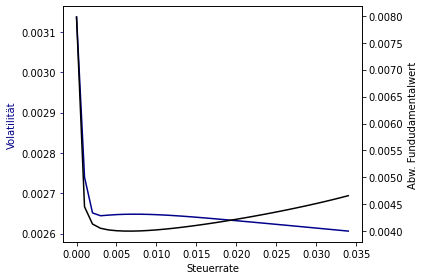

In [39]:
#tax = np.arange(0,0.035,0.001)
#tax = np.arange(0,0.035,0.0005)
fig, ax1 = plt.subplots()

#color = 'tab:red'
ax1.set_xlabel('Steuerrate')
ax1.set_ylabel('Volatilität', color="darkblue")
ax1.plot(tax, vol, color="darkblue")
ax1.tick_params(axis='y', color="darkblue")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:brown'
ax2.set_ylabel('Abw. Fundudamentalwert', color="black")  # we already handled the x-label with ax1
ax2.plot(tax, dis, color="black")
ax2.tick_params(axis='y', color="black")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [49]:
tax = np.arange(0,0.035,0.001)
T = 5000

#dem = np.zeros([numSim, T])
weig_avg = np.zeros([5, len(tax)])
#atrac = np.zeros([numSim, T])


for i in range(len(tax)):
    _,_,_,_,weig= demary_2008(T,30,0,1,0.975,800,tax[i])
    weig_avg[:,i] = np.mean(weig, axis = 1)


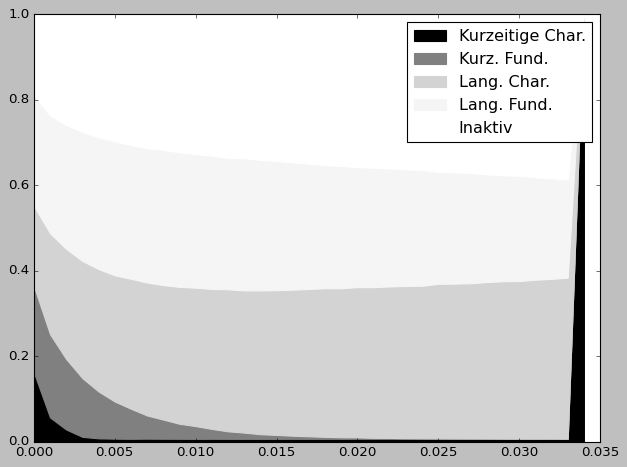

In [164]:
fig, ax = plt.subplots()
#ax.plot(tax,1- weig_avg[1,:]-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], label = "Kurzeitige Char.", color = "black")
ax.fill_between(tax,0, 1- weig_avg[1,:]-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], color = "black", label = "Kurzeitige Char.")

#ax.plot(tax, 1-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], color = "black")
ax.fill_between(tax,1- weig_avg[1,:]-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], 1-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], color = "gray", label = "Kurz. Fund.")

#ax.plot(tax, 1-weig_avg[3,:]-weig_avg[4,:], color = "black")
ax.fill_between(tax,1-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], 1-weig_avg[3,:]-weig_avg[4,:], color = "lightgrey", label = "Lang. Char.")

#ax.plot(tax, 1-weig_avg[4,:], color = "black",label = "Lang. Fund.")
ax.fill_between(tax,1-weig_avg[3,:]-weig_avg[4,:], 1-weig_avg[4,:], color = "whitesmoke",label = "Lang. Fund.")

ax.fill_between(tax,1-weig_avg[4,:], 1, color = "white", label = "Inaktiv")
ax.legend()
plt.tight_layout()

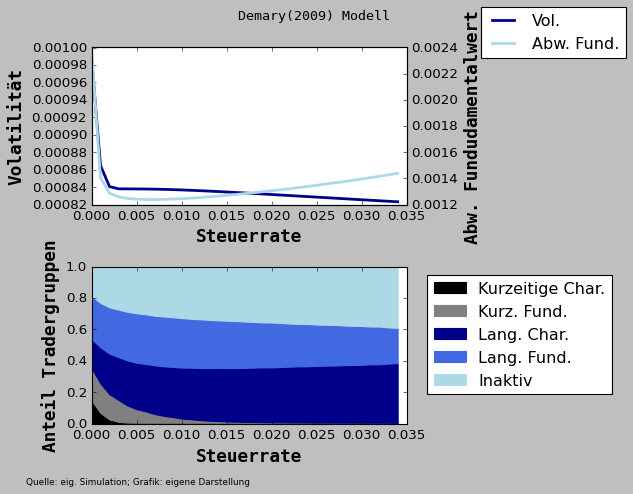

In [61]:
plt.style.use('classic')

font = {'family': 'monospace',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

fig, (ax1, ax3) = plt.subplots(2,1)
fig.suptitle('Demary(2009) Modell', fontdict = font)
tax = np.arange(0,0.035,0.001)
#color = 'tab:red'
ax1.set_xlabel('Steuerrate',fontdict=font)
ax1.set_ylabel('Volatilität',fontdict=font, color="black")
ax1.plot(tax, vol, color="darkblue",label = "Vol.", linewidth=2.5)
ax1.tick_params(axis='y', color="darkblue")


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:brown'
ax2.set_ylabel('Abw. Fundudamentalwert',fontdict=font, color="black")  # we already handled the x-label with ax1
ax2.plot(tax, dis, color="lightblue",label = "Abw. Fund.", linewidth=2.5)
ax2.tick_params(axis='y', color="black")
fig.legend()


tax = np.arange(0,0.035,0.001)
ax3.set_xlabel('Steuerrate',fontdict=font)
ax3.set_ylabel('Anteil Tradergruppen',fontdict=font)
#ax.plot(tax,1- weig_avg[1,:]-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], label = "Kurzeitige Char.", color = "black")
ax3.fill_between(tax,0, 1- weig_avg[1,:]-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], color = "black", label = "Kurzeitige Char.")

#ax.plot(tax, 1-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], color = "black")
ax3.fill_between(tax,1- weig_avg[1,:]-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], 1-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], color = "grey", label = "Kurz. Fund.")

#ax.plot(tax, 1-weig_avg[3,:]-weig_avg[4,:], color = "black")
ax3.fill_between(tax,1-weig_avg[2,:]- weig_avg[3,:]-weig_avg[4,:], 1-weig_avg[3,:]-weig_avg[4,:], color = "darkblue", label = "Lang. Char.")

#ax.plot(tax, 1-weig_avg[4,:], color = "black",label = "Lang. Fund.")
ax3.fill_between(tax,1-weig_avg[3,:]-weig_avg[4,:], 1-weig_avg[4,:], color = "royalblue",label = "Lang. Fund.")

ax3.fill_between(tax,1-weig_avg[4,:], 1, color = "lightblue", label = "Inaktiv")
ax3.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.figtext(0.4, -0.01, "Quelle: eig. Simulation; Grafik: eigene Darstellung", ha="right", fontsize=8)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Demary_Figure.jpeg', bbox_inches = 'tight')